# Data Preprocessing

In [30]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

conn = sqlite3.connect(r'C:\Users\Owner\dev\algobetting\infra\data\db\algobetting.db')

df = pd.read_sql_query("""
                        SELECT DISTINCT
                            f.*,
                            ms.passing_corner_kicks as corner_kicks,
                            ms.opp_passing_corner_kicks as opp_corner_kicks
                        FROM 
                            team_all_features_365_005 f
                        JOIN
                            fbref_match_summary_v2 ms
                                ON ms.match_url = f.match_url
                                AND ms.team = f.team
                        WHERE 
                            f.team_rolling_summary_minutes IS NOT NULL
                       """, conn)

df

,match_url,match_date,season,division,team,opp_team,is_home,gw,is_promoted?,is_early_season?,...,opp_team_rolling_conceded_defense_challenge_tackles_pct,opp_team_rolling_conceded_defense_challenges_lost,opp_team_rolling_conceded_defense_blocked_shots,opp_team_rolling_conceded_defense_blocked_passes,opp_team_rolling_conceded_defense_tackles_interceptions,opp_team_rolling_conceded_defense_clearances,opp_team_rolling_conceded_defense_errors,opp_team_rolling_conceded_keeper_psxg,corner_kicks,opp_corner_kicks
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Tottenham,Brighton,1,38,0,0,...,50.720617,8.796946,3.393454,7.020603,26.403010,27.177737,0.862971,1.299603,2.0,11.0
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Brighton,Tottenham,0,38,0,0,...,57.889854,7.949406,3.378971,9.378588,32.038948,23.558919,0.911136,1.805191,11.0,2.0
2,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Bournemouth,Leicester City,1,38,0,0,...,53.893970,6.606014,2.506894,6.904780,22.901258,21.697324,0.636969,1.811285,6.0,1.0
3,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Leicester City,Bournemouth,0,38,1,0,...,49.279905,7.520887,4.153870,6.746572,23.732322,26.770789,1.451179,1.460762,1.0,6.0
4,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25 00:00:00,2024-2025,Premier League,Newcastle Utd,Everton,1,38,0,0,...,53.064874,6.895930,2.600829,6.075265,24.063503,26.142993,0.567784,1.251694,12.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13 00:00:00,2022-2023,Serie B,Como,Cagliari,1,1,0,1,...,47.905175,6.408071,3.518286,6.676135,21.826232,17.942850,0.219500,1.367898,6.0,5.0
40662,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13 00:00:00,2022-2023,Serie B,Cagliari,Como,0,1,0,1,...,42.604852,8.589310,2.172112,6.611274,23.664988,14.871051,0.075024,1.541054,5.0,6.0
40663,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13 00:00:00,2022-2023,Serie B,Cittadella,Pisa,1,1,0,1,...,47.089937,7.713670,2.909231,6.588752,27.403947,19.741195,0.237578,1.160446,5.0,5.0
40664,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13 00:00:00,2022-2023,Serie B,Pisa,Cittadella,0,1,0,1,...,50.507986,5.815970,3.866474,9.173457,27.363966,20.635355,0.149176,0.957865,5.0,5.0


# EDA

Mean: 4.93
Variance: 7.81
Ratio (should be ~1.0): 0.63

Chi-square test p-value: 0.000
✗ Data does not follow Poisson distribution


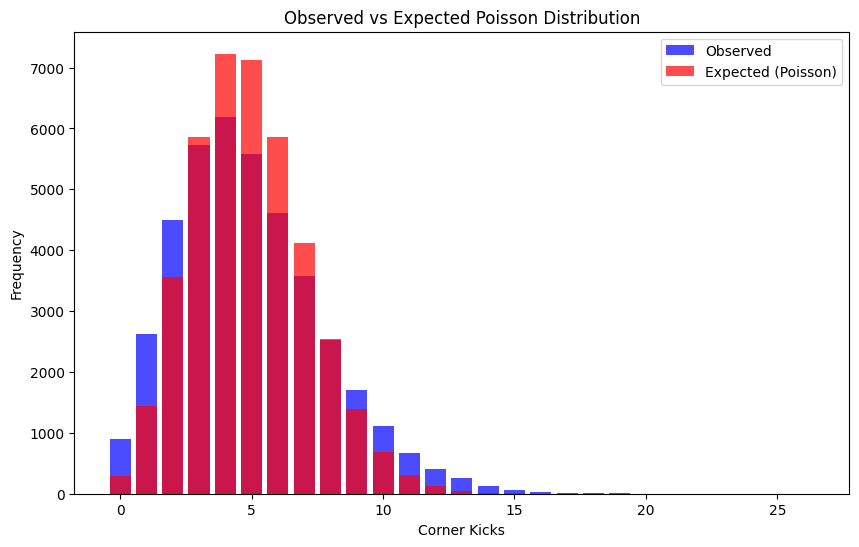

In [31]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simple_poisson_test(data):
   """Simple test for Poisson distribution"""
   data_numeric = pd.to_numeric(data, errors='coerce')
   data_clean = data_numeric.dropna()
   
   mean_val = data_clean.mean()
   var_val = data_clean.var()
   
   print(f"Mean: {mean_val:.2f}")
   print(f"Variance: {var_val:.2f}")
   print(f"Ratio (should be ~1.0): {mean_val/var_val:.2f}")
   
   # Chi-square test
   observed = data_clean.value_counts().sort_index()
   expected = []
   
   for k in observed.index:
       prob = stats.poisson.pmf(k, mean_val)
       expected.append(prob * len(data_clean))
   
   # Force the sums to match exactly
   expected = np.array(expected)
   expected = expected * observed.sum() / expected.sum()
   
   chi2, p_value = stats.chisquare(observed.values, expected)
   
   print(f"\nChi-square test p-value: {p_value:.3f}")
   if p_value > 0.05:
       print("✓ Data likely follows Poisson distribution")
   else:
       print("✗ Data does not follow Poisson distribution")
   
   # Plot comparison
   plt.figure(figsize=(10, 6))
   x = observed.index
   plt.bar(x, observed.values, alpha=0.7, label='Observed', color='blue')
   plt.bar(x, expected, alpha=0.7, label='Expected (Poisson)', color='red')
   plt.xlabel('Corner Kicks')
   plt.ylabel('Frequency')
   plt.title('Observed vs Expected Poisson Distribution')
   plt.legend()
   plt.show()

simple_poisson_test(df["corner_kicks"])

Mean: 4.93
Variance: 7.81
Variance/Mean ratio: 1.58
✓ Data shows overdispersion (variance > mean), negative binomial might be appropriate

Estimated parameters (method of moments):
r (shape): 8.45
p (success probability): 0.631

MLE parameters:
r (shape): 8.35
p (success probability): 0.629

Chi-square test p-value: 0.672
✓ Data consistent with negative binomial distribution


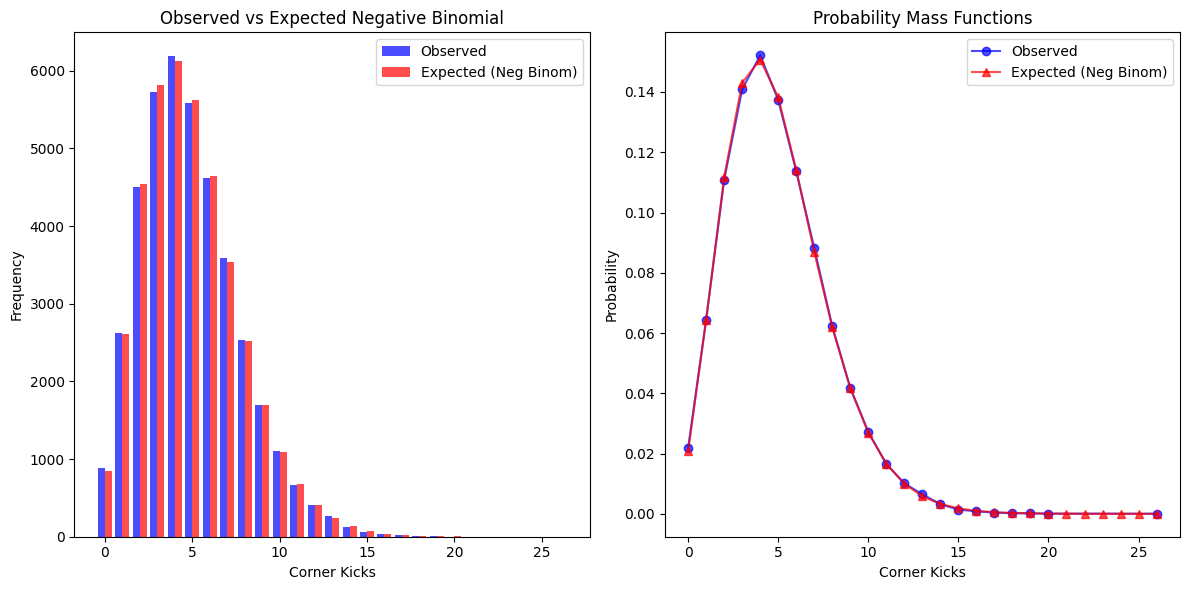

In [32]:
from scipy.optimize import minimize

def negative_binomial_test(data):
    """Test for negative binomial distribution"""
    data_numeric = pd.to_numeric(data, errors='coerce')
    data_clean = data_numeric.dropna()
    
    mean_val = data_clean.mean()
    var_val = data_clean.var()
    
    print(f"Mean: {mean_val:.2f}")
    print(f"Variance: {var_val:.2f}")
    print(f"Variance/Mean ratio: {var_val/mean_val:.2f}")
    
    if var_val/mean_val > 1:
        print("✓ Data shows overdispersion (variance > mean), negative binomial might be appropriate")
    else:
        print("⚠ Data shows underdispersion, Poisson might be better")
    
    # Method of moments estimation for negative binomial parameters
    # For negative binomial: mean = r*p/(1-p), variance = r*p/(1-p)^2
    # This gives us: r = mean^2 / (variance - mean)
    if var_val > mean_val:
        r_est = mean_val**2 / (var_val - mean_val)
        p_est = mean_val / var_val
        
        print(f"\nEstimated parameters (method of moments):")
        print(f"r (shape): {r_est:.2f}")
        print(f"p (success probability): {p_est:.3f}")
        
        # Maximum likelihood estimation (more accurate)
        def neg_log_likelihood(params):
            r, p = params
            if r <= 0 or p <= 0 or p >= 1:
                return np.inf
            return -np.sum(stats.nbinom.logpmf(data_clean, r, p))
        
        # Use method of moments as starting point
        result = minimize(neg_log_likelihood, [r_est, p_est], 
                         bounds=[(0.1, None), (0.001, 0.999)],
                         method='L-BFGS-B')
        
        if result.success:
            r_mle, p_mle = result.x
            print(f"\nMLE parameters:")
            print(f"r (shape): {r_mle:.2f}")
            print(f"p (success probability): {p_mle:.3f}")
            
            # Use MLE parameters for testing
            r_final, p_final = r_mle, p_mle
        else:
            print("MLE failed, using method of moments")
            r_final, p_final = r_est, p_est
        
        # Chi-square goodness of fit test
        observed = data_clean.value_counts().sort_index()
        expected = []
        
        for k in observed.index:
            prob = stats.nbinom.pmf(k, r_final, p_final)
            expected.append(prob * len(data_clean))
        
        expected = np.array(expected)
        expected = expected * observed.sum() / expected.sum()
        
        # Combine small expected frequencies
        min_expected = 5
        obs_combined = []
        exp_combined = []
        current_obs = 0
        current_exp = 0
        
        for i in range(len(observed)):
            current_obs += observed.iloc[i]
            current_exp += expected[i]
            
            if current_exp >= min_expected or i == len(observed) - 1:
                obs_combined.append(current_obs)
                exp_combined.append(current_exp)
                current_obs = 0
                current_exp = 0
        
        if len(obs_combined) > 1:  # Need at least 2 groups for chi-square
            chi2, p_value = stats.chisquare(obs_combined, exp_combined)
            print(f"\nChi-square test p-value: {p_value:.3f}")
            if p_value > 0.05:
                print("✓ Data consistent with negative binomial distribution")
            else:
                print("✗ Data does not fit negative binomial distribution well")
        else:
            print("Not enough data points for chi-square test")
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Bar chart comparison
        plt.subplot(1, 2, 1)
        x = observed.index
        plt.bar(x - 0.2, observed.values, width=0.4, alpha=0.7, label='Observed', color='blue')
        plt.bar(x + 0.2, expected[:len(x)], width=0.4, alpha=0.7, label='Expected (Neg Binom)', color='red')
        plt.xlabel('Corner Kicks')
        plt.ylabel('Frequency')
        plt.title('Observed vs Expected Negative Binomial')
        plt.legend()
        
        # Subplot 2: Probability comparison
        plt.subplot(1, 2, 2)
        x_range = np.arange(0, max(observed.index) + 1)
        obs_probs = observed.values / observed.sum()
        exp_probs = [stats.nbinom.pmf(k, r_final, p_final) for k in x_range]
        
        plt.plot(observed.index, obs_probs, 'bo-', label='Observed', alpha=0.7)
        plt.plot(x_range, exp_probs, 'r^-', label='Expected (Neg Binom)', alpha=0.7)
        plt.xlabel('Corner Kicks')
        plt.ylabel('Probability')
        plt.title('Probability Mass Functions')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return r_final, p_final
    
    else:
        print("Data doesn't show overdispersion - consider Poisson instead")
        return None, None
    
r, p = negative_binomial_test(df["corner_kicks"])

# Feature Engineering

In [33]:
"""
# Engineer interaction features
weighted_attack_cols = [col for col in df.columns if col.startswith('team_rolling_')]

# Create new columns by multiplying weighted_attack columns with their opp_weighted_defense counterparts
for col in weighted_attack_cols:
    # Extract the suffix after 'weighted_attack_'
    suffix = col.replace('team_rolling_', '')
    
    # Construct the corresponding opp_weighted_defense column name
    opp_col = f'opp_team_rolling_{suffix}'
    
    # Check if the corresponding opp column exists
    if opp_col in df.columns:
        # Create new column name for the product
        new_col_name = f'product_{suffix}'
        
        # Multiply the columns
        df[new_col_name] = df[col] * df[opp_col]
        print(f"Created: {new_col_name} = {col} * {opp_col}")
    else:
        print(f"Warning: No matching column found for {col} (looked for {opp_col})")

# Alternative approach: Create a dictionary of all products
products = {}
for col in weighted_attack_cols:
    suffix = col.replace('team_rolling_', '')
    opp_col = f'opp_team_rolling_{suffix}'
    
    if opp_col in df.columns:
        products[f'interaction_{suffix}'] = df[col] * df[opp_col]

# Convert dictionary to DataFrame and concatenate with original
if products:
    products_df = pd.DataFrame(products)
    df_with_products = pd.concat([df, products_df], axis=1)

# Display the new columns created
print("\nNew product columns:")
product_cols = [col for col in df.columns if col.startswith('product_')]
print(product_cols)
"""


'\n# Engineer interaction features\nweighted_attack_cols = [col for col in df.columns if col.startswith(\'team_rolling_\')]\n\n# Create new columns by multiplying weighted_attack columns with their opp_weighted_defense counterparts\nfor col in weighted_attack_cols:\n    # Extract the suffix after \'weighted_attack_\'\n    suffix = col.replace(\'team_rolling_\', \'\')\n    \n    # Construct the corresponding opp_weighted_defense column name\n    opp_col = f\'opp_team_rolling_{suffix}\'\n    \n    # Check if the corresponding opp column exists\n    if opp_col in df.columns:\n        # Create new column name for the product\n        new_col_name = f\'product_{suffix}\'\n        \n        # Multiply the columns\n        df[new_col_name] = df[col] * df[opp_col]\n        print(f"Created: {new_col_name} = {col} * {opp_col}")\n    else:\n        print(f"Warning: No matching column found for {col} (looked for {opp_col})")\n\n# Alternative approach: Create a dictionary of all products\nproducts 

In [34]:
df["match_date"] = pd.to_datetime(df["match_date"])
df["year"] = df["match_date"].dt.year
df["month"] = df["match_date"].dt.month
df["day"] = df["match_date"].dt.day
df["dow"] = df["match_date"].dt.day_of_week

df

,match_url,match_date,season,division,team,opp_team,is_home,gw,is_promoted?,is_early_season?,...,opp_team_rolling_conceded_defense_tackles_interceptions,opp_team_rolling_conceded_defense_clearances,opp_team_rolling_conceded_defense_errors,opp_team_rolling_conceded_keeper_psxg,corner_kicks,opp_corner_kicks,year,month,day,dow
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,2024-2025,Premier League,Tottenham,Brighton,1,38,0,0,...,26.403010,27.177737,0.862971,1.299603,2.0,11.0,2025,5,25,6
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,2024-2025,Premier League,Brighton,Tottenham,0,38,0,0,...,32.038948,23.558919,0.911136,1.805191,11.0,2.0,2025,5,25,6
2,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25,2024-2025,Premier League,Bournemouth,Leicester City,1,38,0,0,...,22.901258,21.697324,0.636969,1.811285,6.0,1.0,2025,5,25,6
3,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25,2024-2025,Premier League,Leicester City,Bournemouth,0,38,1,0,...,23.732322,26.770789,1.451179,1.460762,1.0,6.0,2025,5,25,6
4,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25,2024-2025,Premier League,Newcastle Utd,Everton,1,38,0,0,...,24.063503,26.142993,0.567784,1.251694,12.0,3.0,2025,5,25,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13,2022-2023,Serie B,Como,Cagliari,1,1,0,1,...,21.826232,17.942850,0.219500,1.367898,6.0,5.0,2022,8,13,5
40662,https://fbref.com/en/matches/e8e75a75/Como-Cag...,2022-08-13,2022-2023,Serie B,Cagliari,Como,0,1,0,1,...,23.664988,14.871051,0.075024,1.541054,5.0,6.0,2022,8,13,5
40663,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13,2022-2023,Serie B,Cittadella,Pisa,1,1,0,1,...,27.403947,19.741195,0.237578,1.160446,5.0,5.0,2022,8,13,5
40664,https://fbref.com/en/matches/99979e25/Cittadel...,2022-08-13,2022-2023,Serie B,Pisa,Cittadella,0,1,0,1,...,27.363966,20.635355,0.149176,0.957865,5.0,5.0,2022,8,13,5


# Model Training

In [37]:
df = df.dropna(subset=["corner_kicks"])
X = df.drop(columns=["team", "opp_team", "match_url",  "match_date",  "corner_kicks", "opp_corner_kicks"])
X = pd.get_dummies(X, columns=["season", "division"], drop_first=True)
y = pd.to_numeric(df["corner_kicks"], errors='coerce')

# Log transform to fix gamma deviance error
y_log = np.log(y + 1)

# Use matches after a certain date as test
cutoff_date = '2024-08-01'  # adjust as needed
df['match_date'] = pd.to_datetime(df['match_date'])

train_mask = df['match_date'] < cutoff_date
test_mask = df['match_date'] >= cutoff_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y_log[train_mask]  # Use log-transformed y for training
y_test = y[test_mask]        # Keep original y for evaluation

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_train[test_mask])  # This should be y_log[test_mask] for training, but we'll use for predictions

# Tweedie can handle positive values from log transform
params = {
    'objective': 'reg:tweedie',         
    'tweedie_variance_power': 1.6,      # Based on your variance/mean ratio
    'eval_metric': 'tweedie-nloglik@1.6',   
    'eta': 0.05,                    
    'max_depth': 5,                
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'seed': 26,                     
    'verbosity': 0,
    'reg_alpha': 0.5,              
    'reg_lambda': 2.0,             
    'gamma': 0.5,
    'min_child_weight': 5,
}

# Train model on log-transformed targets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_log[test_mask])  # For evaluation during training

num_rounds = 1000
model = xgb.train(params, dtrain, num_rounds, 
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 early_stopping_rounds=10, verbose_eval=False)

# Make predictions (these will be in log scale)
y_pred_log = model.predict(xgb.DMatrix(X_test))

# Transform predictions back to original scale
y_pred = np.exp(y_pred_log) - 1

# Evaluate model performance using original scale
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Calculate mean absolute error for count data
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# Check prediction variance
pred_var = np.var(y_pred)
actual_var = np.var(y_test)
print(f"Prediction variance: {pred_var:.3f}")
print(f"Actual variance: {actual_var:.3f}")
print(f"Variance ratio (pred/actual): {pred_var/actual_var:.3f}")
print(f"Prediction range: {y_pred.min():.2f} to {y_pred.max():.2f}")
print(f"Actual range: {y_test.min()} to {y_test.max()}")

# Get feature importance
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, score in importance:
    print(f"{feature}: {score:.2f}")

Train size: 35314
Test size: 5320
RMSE: 2.7104
MAE: 2.0776
Prediction variance: 0.826
Actual variance: 8.042
Variance ratio (pred/actual): 0.103
Prediction range: 1.40 to 7.54
Actual range: 0.0 to 26.0

Feature Importance:
opp_team_rolling_conceded_pass_types_crosses: 17.29
is_home: 13.88
team_rolling_possession_touches_att_pen_area: 11.02
opp_team_rolling_conceded_misc_crosses: 9.50
opp_team_rolling_conceded_possession_touches_att_3rd: 9.48
opp_team_rolling_conceded_possession_touches_att_pen_area: 9.39
opp_team_rolling_possession_touches_att_3rd: 9.33
opp_team_rolling_conceded_summary_sca: 9.30
opp_team_rolling_conceded_summary_shots: 8.55
opp_team_rolling_summary_passes_completed: 7.86
opp_team_rolling_defense_clearances: 7.28
team_rolling_pass_types_corner_kicks: 6.87
team_rolling_possession_touches_att_3rd: 6.62
team_rolling_conceded_pass_types_passes: 6.54
opp_team_rolling_conceded_passing_corner_kicks: 6.43
team_rolling_possession_progressive_passes_received: 6.26
team_rolling_p

# Hyperparameter Tuning

In [42]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_gamma_deviance, make_scorer
import pandas as pd
import pickle
import numpy as np

def safe_gamma_deviance(y_true, y_pred):
    """Gamma deviance that ensures both y_true and y_pred are strictly positive"""
    epsilon = 1e-6
    y_true_safe = np.maximum(y_true, epsilon)  # Also fix y_true = 0 cases
    y_pred_safe = np.maximum(y_pred, epsilon)
    return mean_gamma_deviance(y_true_safe, y_pred_safe)

def objective(trial):
    """Simple objective function - using safe gamma deviance"""
    
    # Get the tweedie variance power for the eval metric
    tweedie_power = trial.suggest_float('tweedie_variance_power', 1.2, 1.6)
    
    # Define parameters to tune
    params = {
        'objective': 'reg:tweedie',
        'eval_metric': f'tweedie-nloglik@{tweedie_power}',
        'verbosity': 0,
        'seed': 26,
        'eta': trial.suggest_float('eta', 0.05, 0.15),
        'max_depth': trial.suggest_int('max_depth', 4, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),
        'gamma': trial.suggest_float('gamma', 0.0, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'tweedie_variance_power': tweedie_power,
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params, n_estimators=300)
    
    # Create safe gamma deviance scorer
    safe_scorer = make_scorer(safe_gamma_deviance, greater_is_better=False)
    
    # Use safe gamma deviance scoring
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=safe_scorer)
    
    return scores.mean()

# Run optimization
print(f"Starting optimization with 75 trials...")
print(f"Target range: {y_train.min():.3f} to {y_train.max():.3f} (log-transformed)")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print results
print(f"\nBest score: {study.best_value:.4f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# Train final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'reg:tweedie',
    'eval_metric': f'tweedie-nloglik@{best_params["tweedie_variance_power"]}',
    'verbosity': 0,
    'seed': 26
})

print("\nTraining final model...")
final_model = xgb.XGBRegressor(**best_params, n_estimators=1000, early_stopping_rounds=50)

# For final training, we need to prepare the evaluation set in log scale too
y_test_log = np.log(y_test + 1)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test_log)], verbose=False)

# Make predictions and transform back to original scale
y_pred_log = final_model.predict(X_test)
y_pred = np.exp(y_pred_log) - 1

# Evaluate on original scale
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Check prediction variance
pred_var = np.var(y_pred)
actual_var = np.var(y_test)

print(f"\n=== MODEL EVALUATION (Original Scale) ===")
print(f"Final test MAE: {mae:.4f}")
print(f"Final test RMSE: {rmse:.4f}")
print(f"Prediction variance: {pred_var:.3f}")
print(f"Actual variance: {actual_var:.3f}")
print(f"Variance ratio (pred/actual): {pred_var/actual_var:.3f}")
print(f"Prediction range: {y_pred.min():.2f} to {y_pred.max():.2f}")
print(f"Actual range: {y_test.min()} to {y_test.max()}")

if pred_var/actual_var > 0.3:
    print("✓ Good variance capture!")
else:
    print("⚠ Still too conservative - consider manual parameter adjustment")

# Save results
with open('corners_optuna_results.pkl', 'wb') as f:
    pickle.dump({
        'study': study,
        'best_params': best_params,
        'best_score': study.best_value,
        'final_model': final_model
    }, f)

print(f"\nResults saved to 'corners_optuna_results.pkl'")

# Get feature importance
importance = final_model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Feature Importance:")
for feature, score in importance[:10]:
    print(f"  {feature}: {score:.2f}")

[I 2025-07-11 11:09:39,056] A new study created in memory with name: no-name-a3586c75-3a2b-49e6-b81f-0929faab3a0c


Starting optimization with 75 trials...
Target range: 0.000 to 3.045 (log-transformed)


[I 2025-07-11 11:11:59,980] Trial 0 finished with value: -0.7241688502996402 and parameters: {'tweedie_variance_power': 1.5345197034784315, 'eta': 0.10444744347366891, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.0013913707385671324, 'reg_alpha': 0.24302665684672986, 'reg_lambda': 0.12840445163874573, 'subsample': 0.8519595504183731, 'colsample_bytree': 0.9229631075376573}. Best is trial 0 with value: -0.7241688502996402.
[I 2025-07-11 11:13:39,468] Trial 1 finished with value: -0.6703336271287117 and parameters: {'tweedie_variance_power': 1.4676496730386166, 'eta': 0.0773648420864749, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.2373442318454776, 'reg_alpha': 0.44054573487435206, 'reg_lambda': 0.4631796441125766, 'subsample': 0.9228679013843666, 'colsample_bytree': 0.8844374968811387}. Best is trial 1 with value: -0.6703336271287117.
[I 2025-07-11 11:15:19,062] Trial 2 finished with value: -0.6734576529368993 and parameters: {'tweedie_variance_power': 1.413561627607451, 'eta


Best score: -0.6679
Best parameters:
  tweedie_variance_power: 1.2766
  eta: 0.0619
  max_depth: 7
  min_child_weight: 3
  gamma: 0.2262
  reg_alpha: 0.0076
  reg_lambda: 0.1388
  subsample: 0.9939
  colsample_bytree: 0.7685

Training final model...

=== MODEL EVALUATION (Original Scale) ===
Final test MAE: 2.0829
Final test RMSE: 2.7146
Prediction variance: 0.886
Actual variance: 8.042
Variance ratio (pred/actual): 0.110
Prediction range: 1.15 to 8.09
Actual range: 0.0 to 26.0
⚠ Still too conservative - consider manual parameter adjustment

Results saved to 'corners_optuna_results.pkl'

Top 10 Feature Importance:
  is_home: 21.67
  opp_team_rolling_conceded_possession_touches_att_3rd: 8.49
  opp_team_rolling_conceded_summary_shots: 8.37
  team_rolling_possession_touches_att_pen_area: 7.20
  opp_team_rolling_conceded_passing_corner_kicks: 6.79
  opp_team_rolling_conceded_pass_types_corner_kicks: 6.59
  team_rolling_possession_touches_att_3rd: 6.37
  opp_team_rolling_conceded_misc_cros

In [43]:
print("y_train diagnostics:")
print(f"y_train min: {y_train.min()}")
print(f"y_train max: {y_train.max()}")
print(f"y_train mean: {y_train.mean()}")
print(f"Any NaN in y_train: {np.isnan(y_train).any()}")
print(f"Any inf in y_train: {np.isinf(y_train).any()}")
print(f"y_train dtype: {y_train.dtype}")
print(f"First 10 values: {y_train.head(10).values}")

y_train diagnostics:
y_train min: 0.0
y_train max: 3.044522437723423
y_train mean: 1.6599848335311609
Any NaN in y_train: False
Any inf in y_train: False
y_train dtype: float64
First 10 values: [2.07944154 2.19722458 1.94591015 1.94591015 0.69314718 2.56494936
 2.07944154 1.60943791 1.60943791 1.09861229]


In [44]:
print("=== OPTIMIZED MODEL PARAMETERS ===")
print(final_model.get_params())

=== OPTIMIZED MODEL PARAMETERS ===
{'objective': 'reg:tweedie', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7685296277413244, 'device': None, 'early_stopping_rounds': 50, 'enable_categorical': False, 'eval_metric': 'tweedie-nloglik@1.276632105472543', 'feature_types': None, 'gamma': 0.22621227477676892, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.00761508257656518, 'reg_lambda': 0.13884069588452416, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9939244917369676, 'tree_method': None, 'validate_parameters'

# Error Analysis

In [ ]:
y_pred = best_model.predict(X_test)

# Create new dataframe with selected columns plus predictions
preds = df[['match_url', 'match_date', 'gw', 'season', 'division', 'is_home', 'team', 'opp_team', 'corner_kicks', 'opp_corner_kicks']].copy()

# Add predictions
preds.loc[test_mask, 'predictions'] = y_pred

print(preds[(preds["predictions"].isna()) &  (preds["match_date"] > "2024-08-01")])

# View the result
#preds = preds.dropna(subset=['predictions'])
#preds.to_csv("corner_2425_preds.csv", index=False, encoding='utf-8')

#preds

Empty DataFrame
Columns: [match_url, match_date, gw, season, division, is_home, team, opp_team, corner_kicks, opp_corner_kicks, predictions]
Index: []


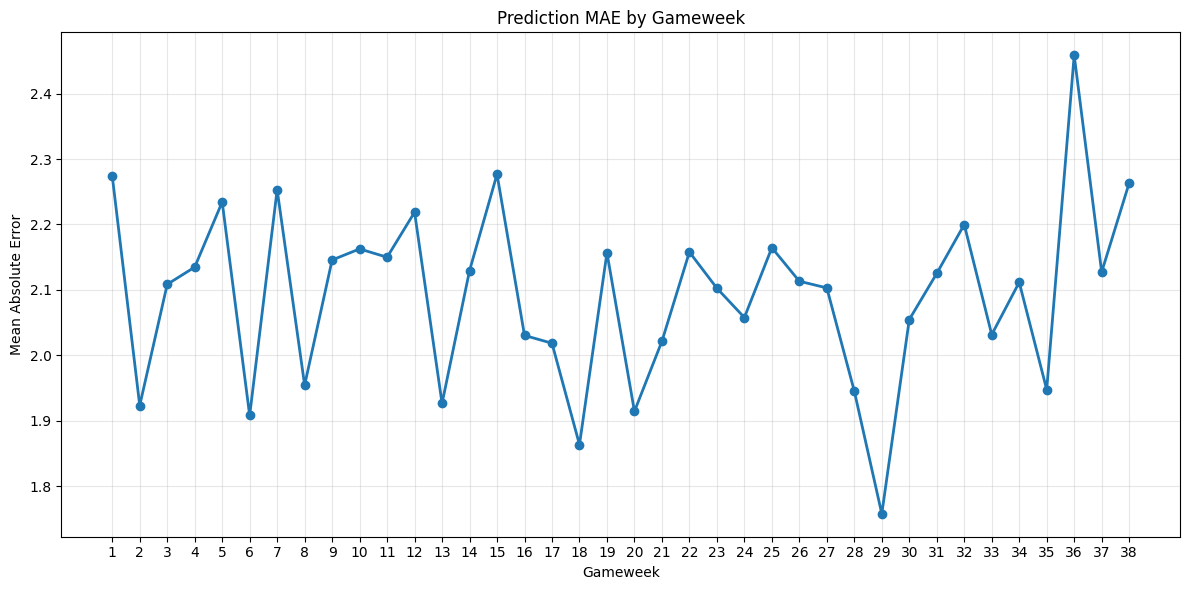

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error

gw_mae = []
gameweeks = sorted(preds['gw'].unique())

for gw in gameweeks:
    gw_data = preds[preds['gw'] == gw]
    if len(gw_data) > 0:
        mae = mean_absolute_error(gw_data['corner_kicks'], gw_data['predictions'])
        gw_mae.append({'gw': gw, 'mae': mae})

# Convert to DataFrame
mae_df = pd.DataFrame(gw_mae)
mae_df = mae_df[mae_df["gw"] <= 38]

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(mae_df['gw'], mae_df['mae'], marker='o', linewidth=2, markersize=6)
plt.xlabel('Gameweek')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction MAE by Gameweek')
plt.grid(True, alpha=0.3)
plt.xticks(mae_df['gw'])
plt.tight_layout()
plt.show()

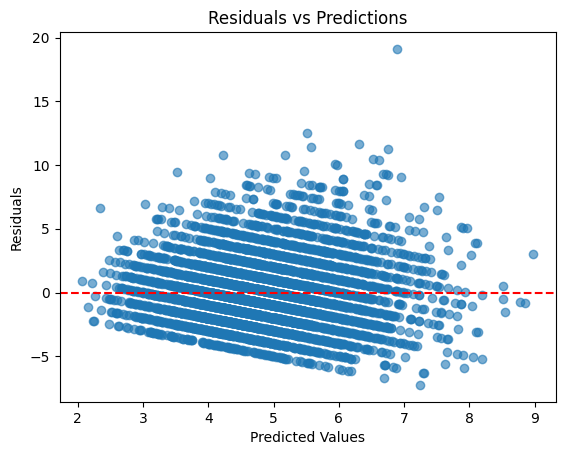

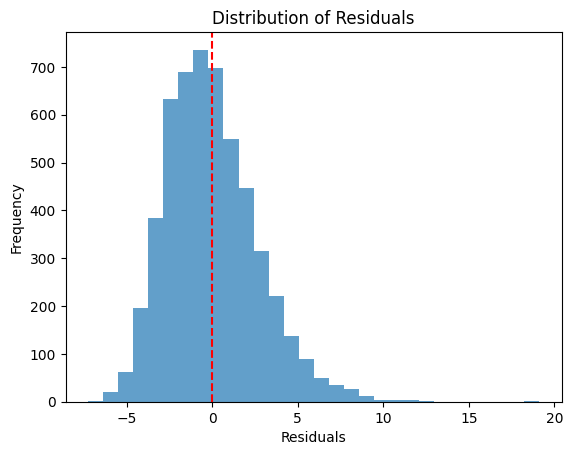

In [ ]:
# Plot residuals vs predictions
residuals = preds['corner_kicks'] - preds['predictions']
plt.scatter(preds['predictions'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

plt.hist(preds['corner_kicks'] - preds['predictions'], bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [ ]:
# By team
team_errors = preds.groupby('team').apply(lambda x: mean_absolute_error(x['corner_kicks'], x['predictions']))

# By division
division_errors = preds.groupby('division').apply(lambda x: mean_absolute_error(x['corner_kicks'], x['predictions']))

# Home vs Away
home_away_errors = preds.groupby('is_home').apply(lambda x: mean_absolute_error(x['corner_kicks'], x['predictions']))

C:\Users\Owner\AppData\Local\Temp\ipykernel_16116\3246406061.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_errors = preds.groupby('team').apply(lambda x: mean_absolute_error(x['corner_kicks'], x['predictions']))
C:\Users\Owner\AppData\Local\Temp\ipykernel_16116\3246406061.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  division_errors = preds.groupby('division').apply(lambda x: mean_absolute_

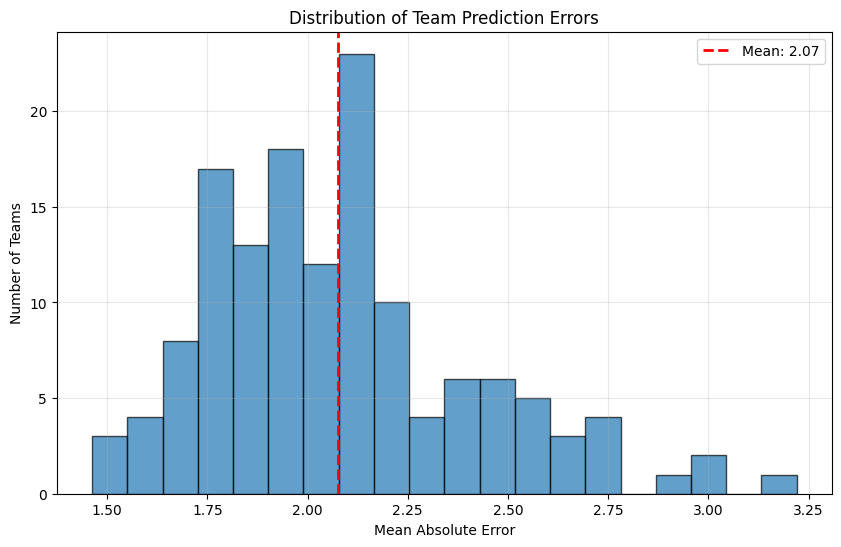

Teams with MAE < 1.5: 1
Teams with MAE > 2.5: 17


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(team_errors, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=team_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {team_errors.mean():.2f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Teams')
plt.title('Distribution of Team Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary stats
print(f"Teams with MAE < 1.5: {(team_errors < 1.5).sum()}")
print(f"Teams with MAE > 2.5: {(team_errors > 2.5).sum()}")

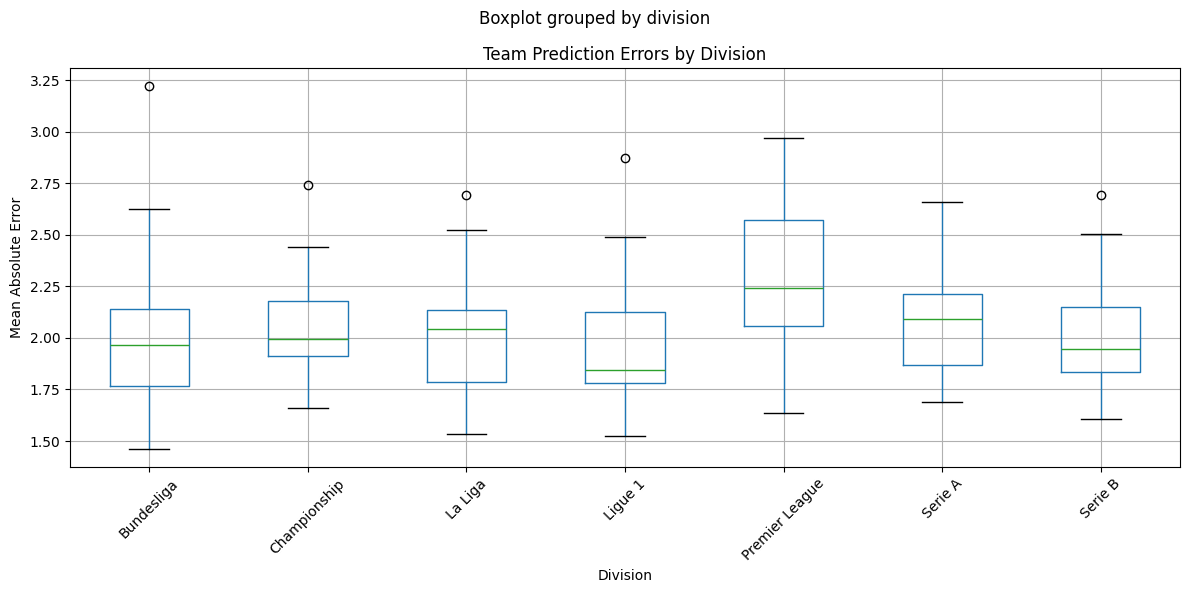


=== WORST PREDICTED TEAMS ===
team
Leverkusen        3.220101
Liverpool         2.970165
Arsenal           2.957032
Paris S-G         2.874567
Aston Villa       2.759248
Coventry City     2.739695
Cosenza           2.695003
Real Madrid       2.693698
Manchester Utd    2.662001
Lazio             2.658466
dtype: float64

Overall Mean MAE: 2.075
Standard Deviation: 0.327


In [ ]:
# Create a dataframe for easier plotting
team_division_errors = []
for team in preds['team'].unique():
    team_data = preds[preds['team'] == team]
    if len(team_data) > 0:
        division = team_data['division'].iloc[0]
        mae = mean_absolute_error(team_data['corner_kicks'], team_data['predictions'])
        team_division_errors.append({'team': team, 'division': division, 'mae': mae})

team_div_df = pd.DataFrame(team_division_errors)

plt.figure(figsize=(12, 6))
team_div_df.boxplot(column='mae', by='division', ax=plt.gca())
plt.title('Team Prediction Errors by Division')
plt.xlabel('Division')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== WORST PREDICTED TEAMS ===")
print(team_errors.nlargest(10))
print(f"\nOverall Mean MAE: {team_errors.mean():.3f}")
print(f"Standard Deviation: {team_errors.std():.3f}")

=== HOME vs AWAY PREDICTION ERRORS ===
is_home
0    1.927356
1    2.233062
dtype: float64

Difference (Home - Away): 0.306


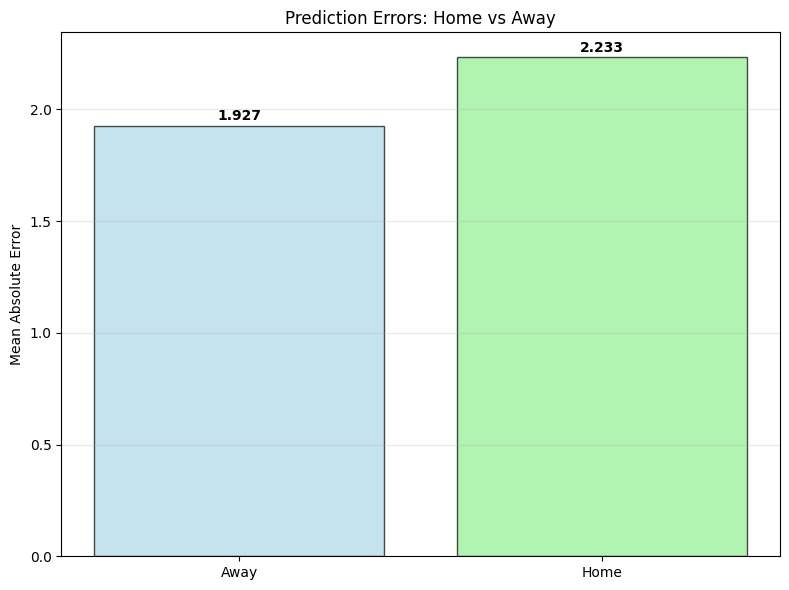

In [ ]:
print("=== HOME vs AWAY PREDICTION ERRORS ===")
print(home_away_errors)
print(f"\nDifference (Home - Away): {home_away_errors[1] - home_away_errors[0]:.3f}")

# Simple bar chart
plt.figure(figsize=(8, 6))
labels = ['Away', 'Home']
errors = [home_away_errors[0], home_away_errors[1]]
colors = ['lightblue', 'lightgreen']

bars = plt.bar(labels, errors, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Errors: Home vs Away')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, error in zip(bars, errors):
   plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{error:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()